In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from matplotlib import ticker

from IPython.display import display

In [2]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [3]:
# всякие константы для последующей работы

#///////////////////////////////// для взятия данных из файлов

path_to_broken_data = 'data\\Новые данные\\Свои данные\\Broken_data.xlsx' # путь к файлу, из которого берутся данные для обучения
path_to_normal_data = 'data\\Новые данные\\Свои данные\\Normal_data.xlsx' # путь к файлу, из которого берутся данные для обучения

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.00005 # шаг сходимости back propogation
#CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 15 # кол-во эпох без улучшений
ES_min_delta = 0.00005 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'val_loss'  # отслеживаемый параметр 
RLPOP_factor = 0.1 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 15 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 1 #13, 4 # размер bach при обучении/тестировании1
FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 200 # количество эпох обучения
FIT_validation_split = 0.15 # процент валидационных данных, отсекаемых из тестовой выборки

In [4]:
# извлечь датасет из файла
def get_df(path: str):
    df = pd.read_excel(path, index_col=0)
    return df

In [5]:
# разбиение данных на тестовые и тренировочные
def split(X,Y,factor):
    X_train=X[:factor]
    Y_train=Y[:factor]
    X_test=X[factor:]
    Y_test=Y[factor:]
    return X_train,Y_train,X_test,Y_test

In [6]:
# подготовить датафрейм к передачи в модель 
#(разбивает числа в ячейках так, что сначала идут 32 числа - амплитуд, потом 32 - времен в одном столбце)
def prepare_df(df):
    new_df = pd.DataFrame()

    for col in df.columns:
        temp = df[col].str.split(pat=':', expand=True)
        new_df[col] = pd.concat([temp[0], temp[1]], axis = 0)
        new_df[col] = new_df[col].astype(float)
    
    new_df['index'] = range(new_df.shape[0])
    new_df = new_df.set_index('index')
    
    return new_df

In [7]:
X = get_df(path_to_broken_data)
Y = get_df(path_to_normal_data)

In [8]:
#display(X)
#display(Y)

In [9]:
# Чтение данных из файла
X = prepare_df(X)
Y = prepare_df(Y)

In [10]:
#display(Y)
#display(X)

In [11]:
X = X.T
Y = Y.T

In [12]:
#display(Y)
#display(X)

In [13]:
print(Y.shape)
print(X.shape)
factor = int(.80 * Y.shape[0])
print(factor)

(250, 64)
(250, 64)
200


In [14]:
factor = int(.80 * Y.shape[0])
X_train, Y_train, X_test, Y_test = split(X, Y, factor)

In [15]:
display(X_train)
display(Y_train)

index,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
column_0,26.02,26.17,26.37,26.54,26.71,26.89,27.41,29.52,29.69,29.86,...,-12.90,17.09,-16.91,12.29,-4.99,-26.92,0.00,0.00,0.00,0.00
column_1,24.93,24.98,25.02,25.08,25.13,25.17,26.13,26.26,28.43,28.47,...,-16.90,22.29,5.14,-14.24,20.08,-18.12,12.44,-5.48,-32.97,0.10
column_2,24.39,24.67,24.94,25.24,25.54,25.80,26.58,26.69,27.00,27.26,...,26.06,-5.36,8.96,-21.06,27.51,-26.55,19.10,-7.66,-22.14,3.89
column_3,25.16,25.38,25.62,25.88,26.12,26.34,27.07,27.77,27.99,28.22,...,-19.29,25.42,-24.81,17.90,-7.16,32.19,0.00,0.00,0.00,0.00
column_4,24.47,24.55,24.64,24.75,24.84,24.95,25.57,27.96,28.05,28.16,...,-15.15,20.96,-19.73,15.21,-6.19,-21.51,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
column_195,26.30,26.58,26.89,27.20,27.51,27.80,28.48,29.01,29.30,29.59,...,-16.36,21.35,-20.62,14.75,-5.93,14.23,0.00,0.00,0.00,0.00
column_196,26.60,26.89,27.19,27.50,27.82,28.09,28.86,29.60,29.90,30.19,...,-14.28,18.60,-17.94,12.87,-5.15,33.40,0.00,0.00,0.00,0.00
column_197,27.10,27.36,27.66,27.94,28.22,28.51,29.24,29.34,30.98,31.26,...,-1.80,-22.91,4.26,-9.94,12.96,-12.59,8.99,-3.63,13.17,-37.18
column_198,25.14,25.21,25.27,25.33,25.40,25.46,26.19,26.29,27.74,27.80,...,0.60,4.87,7.04,-18.57,24.48,-23.45,17.12,-7.10,0.66,-31.32


index,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
column_0,26.02,26.17,26.37,26.54,26.71,26.89,29.52,29.69,29.86,30.03,...,12.29,-4.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_1,24.93,24.98,25.02,25.08,25.13,25.17,28.43,28.47,28.53,28.58,...,12.44,-5.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_2,24.39,24.67,24.94,25.24,25.54,25.80,27.00,27.26,27.56,27.86,...,19.10,-7.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_3,25.16,25.38,25.62,25.88,26.12,26.34,27.77,27.99,28.22,28.46,...,17.90,-7.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_4,24.47,24.55,24.64,24.75,24.84,24.95,27.96,28.05,28.16,28.25,...,15.21,-6.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
column_195,26.30,26.58,26.89,27.20,27.51,27.80,29.01,29.30,29.59,29.89,...,14.75,-5.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_196,26.60,26.89,27.19,27.50,27.82,28.09,29.60,29.90,30.19,30.51,...,12.87,-5.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_197,27.10,27.36,27.66,27.94,28.22,28.51,30.98,31.26,31.55,31.85,...,8.99,-3.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_198,25.14,25.21,25.27,25.33,25.40,25.46,27.74,27.80,27.87,27.93,...,17.12,-7.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
display(X_test)
display(Y_test)

index,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
column_200,26.55,26.66,26.74,26.85,26.94,27.04,27.54,30.47,30.56,30.64,...,-10.69,14.08,-14.22,10.02,-4.15,8.42,0.00,0.00,0.00,0.00
column_201,25.51,25.68,25.87,26.03,26.22,26.39,26.82,29.32,29.49,29.66,...,-12.44,16.38,-16.15,11.61,-4.69,17.11,0.00,0.00,0.00,0.00
column_202,25.29,25.40,25.54,25.67,25.79,25.92,26.88,27.01,28.08,28.21,...,19.11,31.25,7.49,-18.08,23.98,-23.18,17.06,-6.98,-4.82,4.38
column_203,24.83,25.00,25.20,25.40,25.60,25.77,26.72,26.85,28.92,29.10,...,7.84,18.89,5.14,-12.16,16.02,-15.58,11.27,-4.58,7.79,6.10
column_204,26.57,26.79,27.03,27.27,27.51,27.75,29.03,29.21,30.05,30.29,...,11.20,-35.42,5.20,-12.08,15.89,-15.53,11.21,-4.53,7.35,-33.27
column_205,25.35,25.41,25.47,25.53,25.59,25.65,26.73,26.88,29.34,29.40,...,-25.85,21.84,5.00,-12.00,15.70,-14.67,10.78,-4.26,-34.85,-30.45
column_206,24.53,24.74,24.95,25.16,25.37,25.55,26.59,26.73,27.35,27.54,...,10.05,18.10,8.30,-19.37,25.53,-24.90,18.02,-7.39,-27.05,28.52
column_207,24.23,24.31,24.37,24.43,24.49,24.55,25.37,25.49,27.14,27.20,...,32.75,11.92,8.28,-19.81,25.83,-23.76,18.31,-7.42,-23.97,-4.90
column_208,25.08,25.19,25.30,25.41,25.52,25.64,26.68,26.83,28.38,28.49,...,-27.92,-23.83,6.28,-15.33,20.33,-19.79,14.38,-6.08,-4.01,35.44
column_209,25.85,25.93,26.01,26.09,26.17,26.25,26.88,29.45,29.53,29.62,...,-12.93,17.27,-17.14,12.57,-4.90,33.74,0.00,0.00,0.00,0.00


index,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
column_200,26.55,26.66,26.74,26.85,26.94,27.04,30.47,30.56,30.64,30.75,...,10.02,-4.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_201,25.51,25.68,25.87,26.03,26.22,26.39,29.32,29.49,29.66,29.85,...,11.61,-4.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_202,25.29,25.40,25.54,25.67,25.79,25.92,28.08,28.21,28.35,28.46,...,17.06,-6.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_203,24.83,25.00,25.20,25.40,25.60,25.77,28.92,29.10,29.30,29.49,...,11.27,-4.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_204,26.57,26.79,27.03,27.27,27.51,27.75,30.05,30.29,30.53,30.77,...,11.21,-4.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_205,25.35,25.41,25.47,25.53,25.59,25.65,29.34,29.40,29.46,29.52,...,10.78,-4.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_206,24.53,24.74,24.95,25.16,25.37,25.55,27.35,27.54,27.74,27.95,...,18.02,-7.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_207,24.23,24.31,24.37,24.43,24.49,24.55,27.14,27.20,27.28,27.34,...,18.31,-7.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_208,25.08,25.19,25.30,25.41,25.52,25.64,28.38,28.49,28.60,28.71,...,14.38,-6.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
column_209,25.85,25.93,26.01,26.09,26.17,26.25,29.45,29.53,29.62,29.70,...,12.57,-4.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# создание архитектуры нейронки
model = keras.Sequential()

model.add(Input(shape=(64, )))
#model.add(Dense(units = 16, activation='linear'))
#model.add(Dense(units = 256, activation='linear'))
model.add(Dense(units = 1024, activation='linear'))
model.add(Dense(units = 64, activation='linear'))

model.summary()

model.compile(loss = CMP_loss_func, optimizer = CMP_solver)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
Total params: 132,160
Trainable params: 132,160
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [19]:
# тренировка модели
history = model.fit(X_train, 
                    Y_train, 
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_split = FIT_validation_split, 
                    shuffle = FIT_shuffle, 
                    callbacks = FIT_callback_list)

170/170 [==============================] - 0s 371us/step - loss: 0.2538 - val_loss: 0.2470


170/170 [==============================] - 0s 394us/step - loss: 0.1912 - val_loss: 0.1436


  1/170 [..............................] - ETA: 0s - loss: 0.2446
Epoch 00190: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
170/170 [==============================] - 0s 359us/step - loss: 0.1566 - val_loss: 0.1131


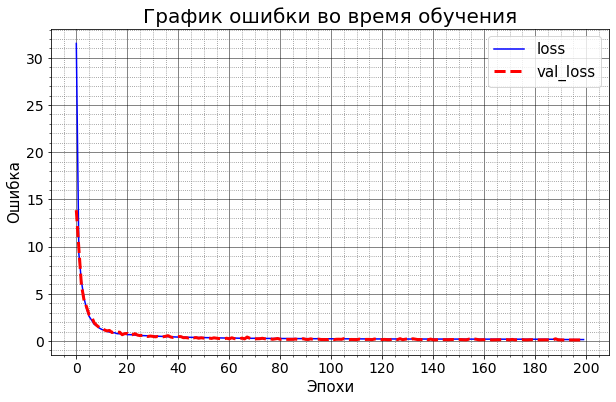

In [20]:
# Вывод графика изменения ошибки

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

plt.plot(history.history['loss'], label='loss',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', label='val_loss',  linewidth=3, color='red')

ax.set_title('График ошибки во время обучения', fontsize=20)
ax.set_ylabel('Ошибка', fontsize=15)
ax.set_xlabel('Эпохи', fontsize=15)

#  Устанавливаем интервал основных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

#  Устанавливаем форматирование чисел основных делений:
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))

#  Устанавливаем форматирование делений:
ax.xaxis.set_tick_params(which = 'major', labelsize = 14)
ax.yaxis.set_tick_params(which = 'major', labelsize = 14)

ax.minorticks_on()
ax.grid(which='major', color = 'k', alpha = 0.6)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 15, facecolor = "white", loc = 'upper right')

plt.show()

In [21]:
# тест модели
model.evaluate(X_test, Y_test, batch_size = FIT_batch_size)

50/50 [==============================] - 0s 338us/step - loss: 0.1126


0.1126411035656929

In [22]:
X_test.shape

(50, 64)

In [23]:
X_test.iloc[:1]

index,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
column_200,26.55,26.66,26.74,26.85,26.94,27.04,27.54,30.47,30.56,30.64,...,-10.69,14.08,-14.22,10.02,-4.15,8.42,0.0,0.0,0.0,0.0


In [24]:
res = model.predict(X_test.iloc[2:3])

In [25]:
temp = X_test.iloc[2:3].to_numpy()

data_df = pd.DataFrame()

data_df['Time'] = temp[0][:32]
data_df['Amplitude'] = temp[0][32:]
data_df = data_df.astype(float)

display(data_df.T)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Time,25.29,25.40,25.54,25.67,25.79,25.92,26.88,27.01,28.08,28.21,...,31.92,32.06,33.69,33.80,33.94,34.07,34.19,34.32,34.46,34.59
Amplitude,19.52,-46.93,62.35,-60.37,44.22,-18.18,-2.49,-26.47,13.97,-33.98,...,19.11,31.25,7.49,-18.08,23.98,-23.18,17.06,-6.98,-4.82,4.38


In [26]:
res_df = pd.DataFrame()
res_df['Time'] = res[0][:32]
res_df['Amplitude'] = res[0][32:]
res_df = res_df.astype(float)
display(res_df.T)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Time,25.251934,25.182264,25.361858,25.692259,26.048828,25.889294,27.948818,27.939602,28.162748,28.622696,...,34.459663,34.528446,35.553951,35.659679,35.918537,35.698509,35.323730,35.595192,35.832069,35.837925
Amplitude,19.950701,-46.951866,62.098885,-60.211140,44.266865,-17.814074,14.503650,-33.961956,44.783363,-44.429996,...,16.755816,-6.725590,0.137661,0.004986,-0.173197,0.092649,-0.059097,-0.229277,-0.098858,0.028104


In [27]:
# начальные данные
x1 = np.array(data_df['Time'])
y1 = np.array(data_df['Amplitude'])

# полученные данные
x2 = np.array(res_df['Time'])
y2 = np.array(res_df['Amplitude'])

In [28]:
'''plt.plot(x1, y1, label='data_df', linestyle = '-')
plt.plot(x2, y2, label='res_df', linestyle = '-')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Результат работы нейронки')

plt.legend(fontsize = 10, facecolor = "white")'''

'plt.plot(x1, y1, label=\'data_df\', linestyle = \'-\')\nplt.plot(x2, y2, label=\'res_df\', linestyle = \'-\')\n\nplt.xlabel(\'Time\')\nplt.ylabel(\'Amplitude\')\nplt.title(\'Результат работы нейронки\')\n\nplt.legend(fontsize = 10, facecolor = "white")'

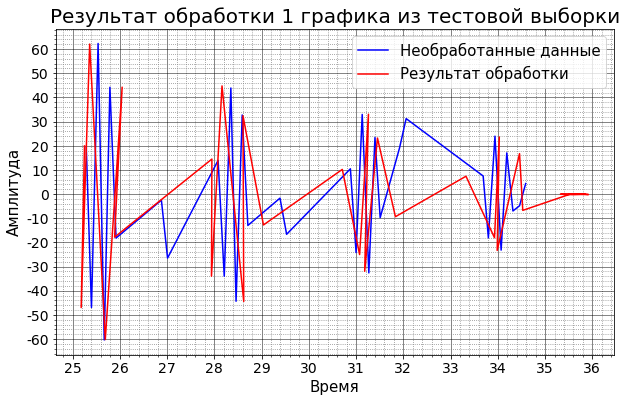

In [29]:
# Вывод графика изменения ошибки

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)


plt.plot(x1, y1, label='Необработанные данные', linestyle = '-', color='blue', linewidth=1.5)
plt.plot(x2, y2, label='Результат обработки', linestyle = '-', color='red', linewidth=1.5)

ax.set_title('Результат обработки 1 графика из тестовой выборки', fontsize=20)
ax.set_xlabel('Время', fontsize=15)
ax.set_ylabel('Амплитуда', fontsize=15)

#  Устанавливаем интервал основных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

#  Устанавливаем форматирование чисел основных делений:
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))

#  Устанавливаем форматирование делений:
ax.xaxis.set_tick_params(which = 'major', labelsize = 14)
ax.yaxis.set_tick_params(which = 'major', labelsize = 14)

ax.minorticks_on()
ax.grid(which='major', color = 'k', alpha = 0.6)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 15, facecolor = "white", loc = 'upper right')

plt.show()

In [30]:
#model.save("NetWork_64_to_64_loss_0,1126")